In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 20*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-01 20:37:50.271820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 20:37:50.519293: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-01 20:37:51.224327: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

In [3]:
sim_names = ["Koch_Meinhardt_1", "Koch_Meinhardt_2", "Koch_Meinhardt_3",
             "Koch_Meinhardt_4", "Koch_Meinhardt_5",
             "Koch_Meinhardt_6", "Koch_Meinhardt_7", "Koch_Meinhardt_9"]
sim_name = sim_names[6]
x_slice=slice(0,99,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,99,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-300,
               data_time_len=60,
               data_time_step=5)

In [4]:
class NN_Field(tu.NN_base):
    def __init__(self, x_range, y_range, depth, dim_2d, layer_num, dtype=tf.float32, **kwargs):
        """A dense Neural Net that is specified by layers argument.

        layers: input, dense layers and outputs dimensions
        lb    : An array of minimums of inputs (lower bounds)
        ub    : An array of maximums of inputs (upper bounds)
        """
        super().__init__(dtype, **kwargs)
        self.depth = depth
        self.layer_num = layer_num
        self.dim_2d = dim_2d
        x = tf.constant(x_range, dtype=dtype)
        y = tf.constant(y_range, dtype=dtype)
        #Y,X = tf.meshgrid(x, y, indexing='ij')
        #X, Y = tf.meshgrid(x, y)
        Y, X = tf.meshgrid(x, y)
        self.X = X
        self.Y = Y
        self.domain_shape = X.shape
        self.build()
        
    def make_variables(self, k, initializer):
        return tf.Variable(initializer(shape=k, dtype=self.dtype))
    
                           
    def build(self):
        """Create the state of the layers (weights)"""
        weights = []
        scales = []
        biases = []
        
        rnd_init = tf.random_normal_initializer(stddev=1/6)
        W = tf.Variable(self.make_variables([self.depth, 3], rnd_init)
                        , dtype=self.dtype)
        #b = tf.Variable(tf.zeros([128, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
        a = tf.Variable(tf.ones([1, 1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
        b = tf.Variable(tf.zeros([1, 1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
        
        weights.append(W)
        scales.append(a)
        biases.append(b)
        for i in range(self.layer_num-1):
            rnd_init = tf.random_normal_initializer(stddev=1/(2*self.depth))
            W = tf.Variable(self.make_variables([self.depth, self.depth], rnd_init)
                        , dtype=self.dtype)
            #b = tf.Variable(tf.zeros([128, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
            a = tf.Variable(tf.ones([1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
            b = tf.Variable(tf.zeros([1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
        
            weights.append(W)
            scales.append(a)
            biases.append(b)
            
        rnd_init = tf.random_normal_initializer(stddev=1/4)
        W = tf.Variable(self.make_variables([2, self.depth], rnd_init)
                        , dtype=self.dtype)
        #b = tf.Variable(tf.zeros([2, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
        a = tf.Variable(tf.ones([1, 1, 2], dtype=self.dtype), dtype=self.dtype)
        b = tf.Variable(tf.zeros([1, 1, 2], dtype=self.dtype), dtype=self.dtype)
        
        weights.append(W)
        scales.append(a)
        biases.append(b)

        self.Ws = weights
        self.scales = scales
        self.bs = biases

    def make_inputs(self, ts):
        T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(self.X.shape)[:, :, tf.newaxis]       
        return T
        
    @tf.function
    def net(self, T):
        #T = tf.fill(self.domain_shape, t)
#         H = tf.concat([tf.expand_dims(self.X, 0), 
#                        tf.expand_dims(self.Y, 0), 
#                        tf.expand_dims(T, 0)], axis=0)
    

    
         
        
        #T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(self.X.shape)[:, :, tf.newaxis]
        #print(T)
        # H will be a tensor (batches, m, n, 3)
        # where batches is the len of ts,
        #       m,n are the width and hieght of the domain
        #       and 3 is for x,y,t
        H = tf.concat([tf.concat([self.X[tf.newaxis, :, :, tf.newaxis], 
                                 self.Y[tf.newaxis, :, :, tf.newaxis],
                                 T[:, :, i:i+1][tf.newaxis, :, :, :]], axis=3) for i in range(T.shape[-1])], axis=0)
        #print(H)
        def act(x):
            return x*tf.sigmoid(x)
        
        for W, a, b in zip(self.Ws, self.scales, self.bs):
            #print(W)
            mul_outputs = tf.tensordot(H, W, axes=[[-1], [-1]])
            #print(mul_outputs)
            outputs =  a * mul_outputs + b
            #outputs =  mul_outputs + b
            #print(outputs)
            #H = tf.tanh(outputs)
            #H = tf.sigmoid(outputs)
            H = act(outputs)
            #print(H)

        return outputs
    
    @tf.function
    def net2(self, t):                
        T = tf.fill(self.domain_shape, t)
        
        H = tf.concat([tf.expand_dims(self.X, 0), 
                       tf.expand_dims(self.Y, 0), 
                       tf.expand_dims(T, 0)], axis=0)
        
        for W, a, b in zip(self.Ws, self.scales, self.bs):
            mul_outputs = tf.tensordot(W, H, axes=[[0], [0]])
            #print(mul_outputs)
            outputs =  a * mul_outputs + b
            #print(outputs)
            H = tf.tanh(outputs)
            #print(H)

        return outputs

    def gradients(self, inputs, outputs):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.

        Return:   The returns 'partial_1' and 'partial_2' are the first and second
                  order gradients, repsectivly. Each one is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, each list has Dn tensors as an elements. The dimensionality
                  of the tensors are the same as inputs: [None, D1]

        """
        partials_1 = [tf.gradients(outputs[:, i], inputs)[0] for i in range(outputs.shape[1])]
        partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
        return partials_1, partials_2



In [17]:
#@tf.function
def grads(pinn, ts):
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(pinn.X)
        tape.watch(pinn.Y)        
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(pinn.X)
            tape2.watch(pinn.Y)
            T = pinn.make_inputs(ts)
            tape2.watch(T)     
            
            outputs = pinn.net(T)
        
            u = outputs[:, :, :, 0]
            v = outputs[:, :, :, 1]
            
        u_x = tape2.gradient(u, pinn.X)
        u_y = tape2.gradient(u, pinn.Y)
        u_t = tape2.gradient(u, T)
        v_x = tape2.gradient(v, pinn.X)
        v_y = tape2.gradient(v, pinn.Y)
        v_t = tape2.gradient(v, T)
            
    u_xx = tape.gradient(u_x, pinn.X)
    u_xy = tape.gradient(u_x, pinn.Y)
    u_yx = tape.gradient(u_y, pinn.X)
    u_yy = tape.gradient(u_y, pinn.Y)
    v_xx = tape.gradient(v_x, pinn.X)
    v_yy = tape.gradient(v_y, pinn.Y)
    v_xy = tape.gradient(v_x, pinn.Y)
    v_yx = tape.gradient(v_y, pinn.X)
    #return (u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t)
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_xy), tf.squeeze(u_yx), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_xy), tf.squeeze(v_yx), tf.squeeze(v_t))


In [5]:
def gen_series():    
    for i,t in enumerate(pattern.t_star):
        yield t, pattern.c[..., i]
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((), pattern.c.shape[:-1]))

In [6]:
pattern.t_star.shape

(12,)

In [11]:

x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]

optimizer=keras.optimizers.Adam(learning_rate=2e-4)
pinn = NN_Field(x_range, y_range, 
                depth=32, 
                dim_2d=(pattern.block_x, pattern.block_x), 
                layer_num = 6,
                dtype=tf.float32)
norm_l2 = L2()

init_per = 2.0
D_u = tf.constant(pattern.params["D_u"], pinn.dtype, name="D_u")#tf.Variable(pattern.params["D_u"]*init_per, pinn.dtype)
D_v = tf.constant(pattern.params["D_v"], pinn.dtype, name="D_v")#tf.Variable(pattern.params["D_v"]*init_per, pinn.dtype)
def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 0, 1e10,)

sigma_u = tf.Variable(pattern.params["sigma_u"]*init_per,
                      pinn.dtype,
                      name="sigma_u",
                      constraint=clip_by_value_zero_lb)


sigma_v = tf.Variable(pattern.params["sigma_v"]*init_per,
                      pinn.dtype,
                      name="sigma_v",
                      constraint=clip_by_value_zero_lb)

mu_u = tf.Variable(pattern.params["mu_u"]*init_per,
                   pinn.dtype,
                   name="mu_u",
                   constraint=clip_by_value_zero_lb)

rho_u = tf.Variable(pattern.params["rho_u"]*init_per,
                    pinn.dtype,
                    name="rho_u",
                    constraint=clip_by_value_zero_lb)

rho_v = tf.Variable(pattern.params["rho_v"]*init_per,
                    pinn.dtype,
                    name="rho_v",
                    constraint=clip_by_value_zero_lb)

kappa_u = tf.Variable(pattern.params["kappa_u"]*init_per,
                      pinn.dtype,
                      name="kappa_u",
                      constraint=clip_by_value_zero_lb)


params_tf = (sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,)

@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        tape.watch(pinn.X)
        tape.watch(pinn.Y)
        #tape.watch(t)
        trainables = pinn.trainable_variables
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(pinn.X)
            tape2.watch(pinn.Y)
            T = pinn.make_inputs(elements[0])
            #tape2.watch(T)
            
            outputs = pinn.net(T)            
            u = outputs[:, :, :, 0]
            v = outputs[:, :, :, 1]
            
            u_x = tape2.gradient(u, pinn.X)
            u_y = tape2.gradient(u, pinn.Y)
            #u_t = tape2.gradient(u, T)
            #u_t = tf.einsum("ijt -> tij", u_t)
            
            v_x = tape2.gradient(v, pinn.X)
            v_y = tape2.gradient(v, pinn.Y)
            #v_t = tape2.gradient(v, T)
            #v_t = tf.einsum("ijt -> tij", v_t)
            
        
        u_xx = tape.gradient(u_x, pinn.X)
        #u_xy = tape.gradient(u_x, pinn.Y)
        #u_yx = tape.gradient(u_y, pinn.X)
        u_yy = tape.gradient(u_y, pinn.Y)
        v_xx = tape.gradient(v_x, pinn.X)
        v_yy = tape.gradient(v_y, pinn.Y)
        #v_xy = tape.gradient(v_x, pinn.Y)
        #v_yx = tape.gradient(v_y, pinn.X)
        #print(u_xx)
        #partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
               
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u# - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v# - v_t
        
        #print(u.shape)
        #print(u_xx.shape)
        #u_xyyx_diff = u_xy - u_yx
        #v_xyyx_diff = v_xy - v_yx

        #diff = outputs - elements[1] 
        #print(elements[1].shape)
        u_diff = u - elements[1][:, 0, :, :]
        v_diff = v - elements[1][:, 1, :, :]
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)


        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
        #l2_res_u_xyyx = tf.reduce_sum(u_xyyx_diff**2)
        #l2_res_v_xyyx = tf.reduce_sum(v_xyyx_diff**2)
        
        l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v #+ l2_res_u_xyyx + l2_res_v_xyyx
        
       
    grads = tape.gradient(l2, trainables + params_tf)
    optimizer.apply_gradients(zip(grads, trainables + params_tf))
    return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v)#, l2_res_u_xyyx, l2_res_v_xyyx)


In [12]:
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f" u: {losses[0]}, v: {losses[1]},\n"
            f" Res u: {losses[2]}, Res v: {losses[3]} \n")
    printer(#f"D_u: {D_u.numpy()}, D_v: {D_v.numpy()} \n"
            f"rho_u: {rho_u.numpy()}, rho_v: {rho_v.numpy()} \n"
            f"sigma_u: {sigma_u.numpy()}, sigma_v: {sigma_v.numpy()} \n"
            f"kappa_u: {kappa_u.numpy()}, mu_u: {mu_u.numpy()} \n")
            #f" Res u xyyx: {losses[4]}, Res v xyyx: {losses[5]}")
losses = tu.train(epochs=50000+1,
                  batch_size=1,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0


2023-02-01 20:44:13.673273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-01 20:44:13.721733: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb3f8055190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-01 20:44:13.721785: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-02-01 20:44:13.729475: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-01 20:44:14.229656: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


at epoch 0
 total loss: 1063246.25 u: 830.3555908203125, v: 1023298.0625,
 Res u: 6.268618513161073e-09, Res v: 39117.78125 

rho_u: 0.08000021427869797, rho_v: 3.001418352127075 
sigma_u: 0.0001924227544805035, sigma_v: 1.9975996017456055 
kappa_u: 2.0, mu_u: 0.19940979778766632 

Time taken: 18.81s

Start of epoch 500
at epoch 500
 total loss: 29355.6953125 u: 136.711669921875, v: 29212.841796875,
 Res u: 0.006755175534635782, Res v: 6.136378288269043 

rho_u: 0.06451139599084854, rho_v: 3.0046966075897217 
sigma_u: 0.005857653915882111, sigma_v: 1.9722051620483398 
kappa_u: 2.006675958633423, mu_u: 0.1760287582874298 

Time taken: 247.13s

Start of epoch 1000
at epoch 1000
 total loss: 28311.314453125 u: 134.5118865966797, v: 28132.46484375,
 Res u: 0.009883868508040905, Res v: 44.32897186279297 

rho_u: 0.05828214809298515, rho_v: 3.010921001434326 
sigma_u: 0.0019822530448436737, sigma_v: 1.9496642351150513 
kappa_u: 2.0162830352783203, mu_u: 0.14610649645328522 

Time taken: 247.


Start of epoch 12500
at epoch 12500
 total loss: 44.077552795410156 u: 1.2679686546325684, v: 36.622100830078125,
 Res u: 0.07627292722463608, Res v: 6.111215591430664 

rho_u: 0.06600933521986008, rho_v: 2.2184500694274902 
sigma_u: 0.0, sigma_v: 1.1715623140335083 
kappa_u: 3.5222744941711426, mu_u: 0.12819090485572815 

Time taken: 235.20s

Start of epoch 13000
at epoch 13000
 total loss: 42.867332458496094 u: 1.192180871963501, v: 33.923988342285156,
 Res u: 0.07880481332540512, Res v: 7.672360420227051 

rho_u: 0.06566520035266876, rho_v: 2.197110176086426 
sigma_u: 0.0, sigma_v: 1.1554487943649292 
kappa_u: 3.538358211517334, mu_u: 0.12704646587371826 

Time taken: 235.51s

Start of epoch 13500
at epoch 13500
 total loss: 43.45658493041992 u: 0.9642978310585022, v: 37.88731384277344,
 Res u: 0.07368617504835129, Res v: 4.53128719329834 

rho_u: 0.06527543812990189, rho_v: 2.1769649982452393 
sigma_u: 0.0, sigma_v: 1.1418992280960083 
kappa_u: 3.5461621284484863, mu_u: 0.12616011


Start of epoch 24500
at epoch 24500
 total loss: 13.854435920715332 u: 0.5595887899398804, v: 11.23432731628418,
 Res u: 0.03828718885779381, Res v: 2.022233009338379 

rho_u: 0.06157885491847992, rho_v: 1.9429091215133667 
sigma_u: 0.0, sigma_v: 1.0782654285430908 
kappa_u: 2.859635591506958, mu_u: 0.12745141983032227 

Time taken: 241.38s

Start of epoch 25000
at epoch 25000
 total loss: 11.434488296508789 u: 0.5403369665145874, v: 9.23215103149414,
 Res u: 0.036053355783224106, Res v: 1.6259469985961914 

rho_u: 0.06111164391040802, rho_v: 1.9266060590744019 
sigma_u: 0.0, sigma_v: 1.0744845867156982 
kappa_u: 2.801955461502075, mu_u: 0.1271725445985794 

Time taken: 232.48s

Start of epoch 25500
at epoch 25500
 total loss: 11.413804054260254 u: 0.4855346083641052, v: 9.220219612121582,
 Res u: 0.03331388533115387, Res v: 1.67473566532135 

rho_u: 0.06059345602989197, rho_v: 1.9115313291549683 
sigma_u: 0.0, sigma_v: 1.0711954832077026 
kappa_u: 2.74623703956604, mu_u: 0.1267562806


Start of epoch 36500
at epoch 36500
 total loss: 5.241090774536133 u: 0.1370728313922882, v: 4.269043922424316,
 Res u: 0.007695254869759083, Res v: 0.827278733253479 

rho_u: 0.04904962703585625, rho_v: 1.655043363571167 
sigma_u: 0.0, sigma_v: 1.017661213874817 
kappa_u: 1.7718714475631714, mu_u: 0.1130317896604538 

Time taken: 232.14s

Start of epoch 37000
at epoch 37000
 total loss: 4.765738487243652 u: 0.13779288530349731, v: 3.8259775638580322,
 Res u: 0.00694006122648716, Res v: 0.7950281500816345 

rho_u: 0.048728227615356445, rho_v: 1.6484861373901367 
sigma_u: 0.0, sigma_v: 1.0164543390274048 
kappa_u: 1.7452114820480347, mu_u: 0.11257394403219223 

Time taken: 232.52s

Start of epoch 37500
at epoch 37500
 total loss: 5.224135398864746 u: 0.13466113805770874, v: 4.383143424987793,
 Res u: 0.006399056874215603, Res v: 0.6999315023422241 

rho_u: 0.04848962649703026, rho_v: 1.642008662223816 
sigma_u: 0.0, sigma_v: 1.0151023864746094 
kappa_u: 1.7183257341384888, mu_u: 0.1121


Start of epoch 48500
at epoch 48500
 total loss: 2.810060739517212 u: 0.04111195728182793, v: 2.2835569381713867,
 Res u: 0.0017035419587045908, Res v: 0.48368844389915466 

rho_u: 0.042977310717105865, rho_v: 1.5370005369186401 
sigma_u: 2.1432349967653863e-05, sigma_v: 0.993831217288971 
kappa_u: 1.2863428592681885, mu_u: 0.10410937666893005 

Time taken: 232.69s

Start of epoch 49000
at epoch 49000
 total loss: 3.1563966274261475 u: 0.04196642339229584, v: 2.5180816650390625,
 Res u: 0.0015882765874266624, Res v: 0.5947601795196533 

rho_u: 0.042786695063114166, rho_v: 1.5336824655532837 
sigma_u: 3.1699950341135263e-05, sigma_v: 0.9932612776756287 
kappa_u: 1.272542953491211, mu_u: 0.10386950522661209 

Time taken: 233.15s

Start of epoch 49500
at epoch 49500
 total loss: 4.048103332519531 u: 0.04257532209157944, v: 3.4134907722473145,
 Res u: 0.0014403627719730139, Res v: 0.5905970335006714 

rho_u: 0.042669862508773804, rho_v: 1.530695915222168 
sigma_u: 3.61142483598087e-05, si

In [ ]:
'rho_u': 0.04  , 'rho_v': 1.5,
'sigma_u': 0.0, 'sigma_v': 1.0,
'kappa_u': 1.0, 'mu_u': 0.1,

In [47]:
def Euclidian_L(vec1, vec2):
    def L(v):
        return np.sqrt(np.sum(v**2))
    v2 = vec2.copy()
    v2[v2==0] = 1
    return L((vec1-vec2)/v2)

u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["mu_u"],
                     pattern.params["sigma_u"], pattern.params["kappa_u"]])

u_vec    = np.array([rho_u.numpy(), mu_u.numpy(), sigma_u.numpy(), kappa_u.numpy()])

v_vec_ac = np.array([pattern.params["rho_v"], 
                     pattern.params["sigma_v"], pattern.params["kappa_u"]])

v_vec    = np.array([rho_v.numpy(), sigma_v.numpy(), kappa_u.numpy()])

print(f"U params. estimates: {Euclidian_L(u_vec, u_vec_ac)}")
print(f"V params. estimates: {Euclidian_L(v_vec, v_vec_ac)}")

U params. estimates: 0.25747114502186347
V params. estimates: 0.24757113443935416


In [13]:
pattern.params

{'D_u': 0.1,
 'D_v': 1.0,
 'kappa_u': 1.0,
 'rho_u': 0.04,
 'mu_u': 0.1,
 'sigma_u': 0.0,
 'rho_v': 1.5,
 'sigma_v': 1.0}

In [14]:
def sum_per(arr, element_nums_by=2):
    return np.sum(arr.reshape(-1, element_nums_by), axis=1)

losses2 = np.array(losses )
element_nums_by = 12#len(losses)//2
losses2 =np.concatenate([sum_per(losses2[:, 0], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 1], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 2], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 3], element_nums_by)[:, np.newaxis],                        
                        ], axis=1)

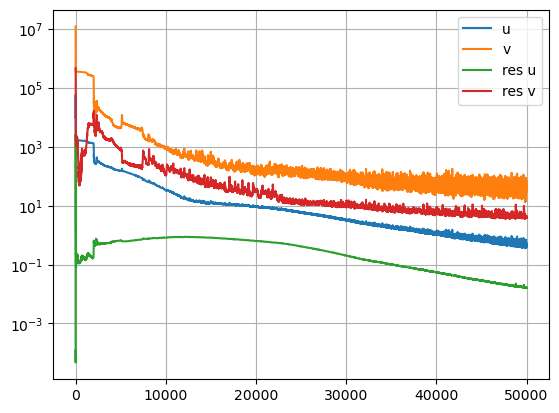

In [15]:
plt.plot(losses2[:, 0], label='u')
plt.plot(losses2[:, 1], label='v')
plt.plot(losses2[:, 2], label='res u')
plt.plot(losses2[:, 3], label='res v')
plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

In [20]:
(u, u_xx, u_yy, u_xy, u_yx, u_t, 
 v, v_xx, v_yy, v_xy, v_yx, v_t) = grads(pinn, pattern.t_star[-1:].astype(np.float32))

In [25]:
def RMSE(arr1, arr2):
    #return np.sqrt(np.mean(((arr1-arr2)/np.max(arr2))**2))
    return np.sqrt(np.mean(((arr1-arr2)/(arr2+1e-20))**2))
                          
print("u: ", RMSE(u, pattern.c[0,:, : , -1]))
print("v: ", RMSE(v, pattern.c[1,:, : , -1]))
print("u_xx: ", RMSE(u_xx, pattern.c_xx[0,:, : , -1]))
print("v_xx: ", RMSE(v_xx, pattern.c_xx[1,:, : , -1]))
print("u_yy: ", RMSE(u_yy, pattern.c_yy[0,:, : , -1]))
print("v_yy: ", RMSE(v_yy, pattern.c_yy[1,:, : , -1]))
print("u_t: ", RMSE(u_t, pattern.c_t[0,:, : , -1]))
print("v_t: ", RMSE(v_t, pattern.c_t[1,:, : , -1]))

u:  0.009388743
v:  0.0019912587
u_xx:  4.5288386
v_xx:  22.313026
u_yy:  17.08973
v_yy:  0.76607525
u_t:  182.91858
v_t:  78.542244


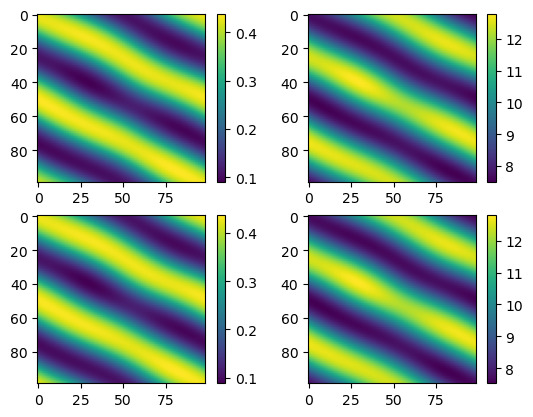

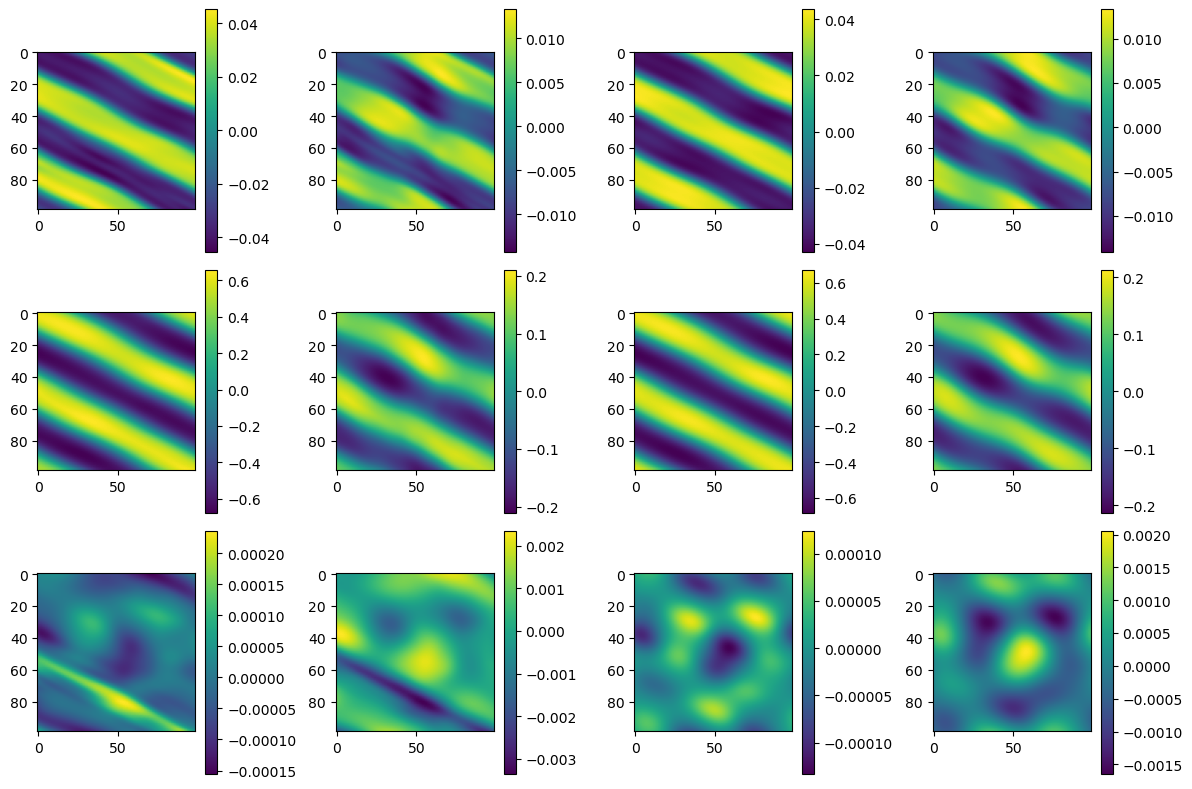

In [22]:
plt.subplot(221)
plt.imshow(u)
plt.colorbar()
plt.subplot(222)
plt.imshow(v)
plt.colorbar()
plt.subplot(223)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(u_xx)
plt.colorbar()
plt.subplot(342)
plt.imshow(u_yy)
plt.colorbar()
plt.subplot(343)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(v_xx)
plt.colorbar()
plt.subplot(346)
plt.imshow(v_yy)
plt.colorbar()
plt.subplot(347)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(u_t)
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(v_t)
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()

In [26]:
from scipy.optimize import lsq_linear
from scipy import linalg

u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["mu_u"],
                     pattern.params["sigma_u"], pattern.params["kappa_u"]])

u_vec    = np.array([rho_u.numpy(), mu_u.numpy(), sigma_u.numpy(), kappa_u.numpy()])

v_vec_ac = np.array([pattern.params["rho_v"], 
                     pattern.params["sigma_v"], pattern.params["kappa_u"]])

v_vec    = np.array([rho_v.numpy(), sigma_v.numpy(), kappa_u.numpy()])

params2 = np.concatenate([u_vec[:-1], v_vec[:-1]])
params3 = np.concatenate([u_vec_ac[:-1], v_vec_ac[:-1]])

u_sol = u.numpy().flatten()
v_sol = v.numpy().flatten()
n2 = u_sol.shape[0]
kappa_sol = kappa_u.numpy()#pde_resKM.kappa_u.get_value(0).numpy()[0]

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)


uxxyy_sol = D_u.numpy()*(u_xx.numpy() + u_yy.numpy()).flatten()
vxxyy_sol = D_v.numpy()*(v_xx.numpy() + v_yy.numpy()).flatten()

A_sol =  np.vstack((np.c_[f_sol,  u_sol,  [1]*n2, [0]*n2, [0]*n2],
                    np.c_[[0]*n2, [0]*n2, [0]*n2,-f_sol,  [1]*n2]))


u_dt_sol = (u_t.numpy()).flatten()
v_dt_sol = (v_t.numpy()).flatten()

b_sol =  np.r_[(u_dt_sol-uxxyy_sol, v_dt_sol-vxxyy_sol)]

In [27]:
np.sqrt(np.mean(((np.dot(A_sol, params2)-b_sol))**2))

0.04317305633940635

In [28]:
np.sqrt(np.mean(((np.dot(A_sol, params3)-b_sol))**2))

0.045566842217783454